In [146]:
import pandas as pd
import requests
import zipfile
import geopandas as gpd
from io import BytesIO
import matplotlib.pyplot as plt
from shapely.geometry import Point, box
import os
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import atlite
import geopandas as gpd
import numpy as np

### Line loading analysis

#### A) GIS Nuts-3 file: Germany

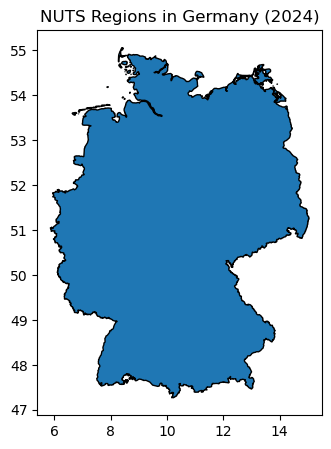

In [2]:
eu = gpd.read_file(r"C:\Users\par19744\Python_projects\ASSUME_project\ASSUME_Use_case\shapefile_data\NUTS_RG_01M_2024_4326_LEVL_0.shp.zip")
germany_nuts3 = eu[eu['CNTR_CODE'] == 'DE']
germany_nuts3.plot(figsize=(5, 5), edgecolor="black")
plt.title("NUTS Regions in Germany (2024)")
plt.show()

#### B) Buses

In [3]:
# Load buses data
buses_df = pd.read_csv("buses.csv")
buses_df=buses_df[['name','v_nom','x','y','carrier']]

# Convert buses DataFrame to a GeoDataFrame using longitude (x) and latitude (y)
geometry = [Point(xy) for xy in zip(buses_df['x'], buses_df['y'])]
buses_gdf = gpd.GeoDataFrame(buses_df, geometry=geometry, crs="EPSG:4326")

# Ensure the CRS matches between the NUTS3 shapefile and buses GeoDataFrame
buses_gdf = buses_gdf.to_crs(germany_nuts3.crs)

# Perform a spatial join to classify nodes into NUTS3 regions
buses_NUTS3 = gpd.sjoin(buses_gdf, germany_nuts3, how="left", predicate="within")

# Display the classified buses with their NUTS3 region info
buses_NUTS3 = buses_NUTS3[['name', 'x', 'y', 'NUTS_ID', 'geometry']]

# Explicitly convert classified_buses to a GeoDataFrame, ensuring geometry is set
buses_NUTS3 = gpd.GeoDataFrame(buses_NUTS3, geometry="geometry", crs=germany_nuts3.crs)
buses_NUTS3.head(2)

,name,x,y,NUTS_ID,geometry
0,DE1-220,13.677140,54.817281,NaN,POINT (13.67714 54.81728)
1,DE10-380,9.552734,53.563511,DE,POINT (9.55273 53.56351)


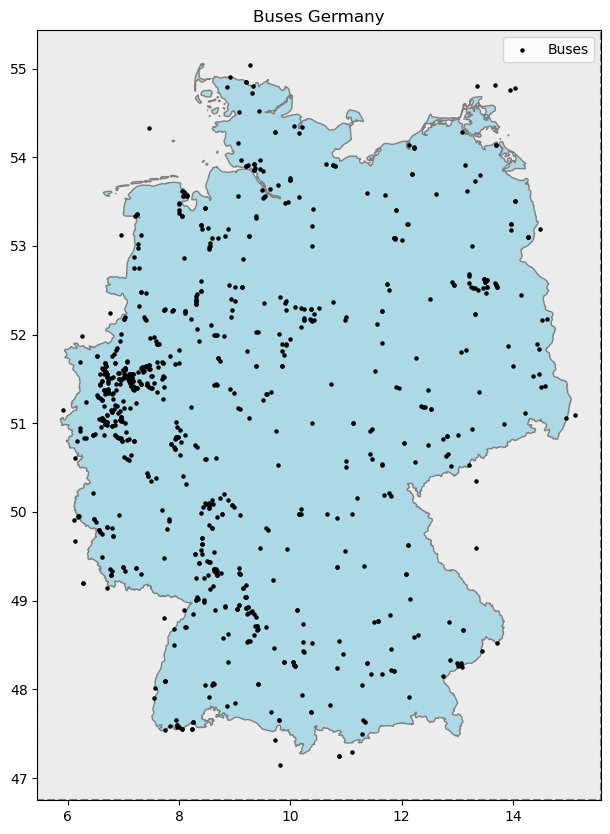

In [4]:
# Get the bounding box of the classified buses
bbox = buses_NUTS3.total_bounds  # [minx, miny, maxx, maxy]

# Calculate the center of the bounding box
center = [(bbox[0] + bbox[2]) / 2, (bbox[1] + bbox[3]) / 2]

# Calculate the width and height of the bounding box with a margin
width = bbox[2] - bbox[0]
height = bbox[3] - bbox[1]
new_bbox = box(
    center[0] - width * 0.55, center[1] - height * 0.55,
    center[0] + width * 0.55, center[1] + height * 0.55
)

# Convert the bounding box to a GeoSeries
new_bbox = gpd.GeoSeries([new_bbox], crs=buses_NUTS3.crs)

# Plot the map for Germany with buses classified by NUTS3 regions
fig, ax = plt.subplots(figsize=(10, 10))
# Set background color to light gray
ax.set_facecolor("#ececec")

germany_nuts3.plot(ax=ax, edgecolor="gray", color="lightblue", alpha=1)
buses_NUTS3.plot(ax=ax, color="black", label="Buses", markersize=5)
new_bbox.boundary.plot(ax=ax, color="gray", linestyle="--")

plt.title("Buses Germany")
plt.legend()
plt.xlim(new_bbox.total_bounds[0], new_bbox.total_bounds[2])
plt.ylim(new_bbox.total_bounds[1], new_bbox.total_bounds[3])
plt.show()

#### C) Lines

In [5]:
# load powerplants_df csv file
lines_df = pd.read_csv('lines.csv')
lines_df=lines_df[['name','bus0','bus1','s_nom']]
lines_df.head(5)

,name,bus0,bus1,s_nom
0,merged_relation/1208415-380-c+1,way/23380800-380,way/24478889-380,1698.103
1,merged_way/24532884-1-380+6,way/23380800-380,way/24479984-380,1698.103
2,merged_relation/14592471-380-b+1,way/25306752-380,way/31131325-380,1698.103
3,way/167261399-1-380,way/25306752-380,DE199-380,1698.103
4,merged_way/36964218-1-380+2,DE198-380,DE199-380,1698.103


In [6]:
# Extract relevant columns from buses_df
buses_coords = buses_df[['name', 'x', 'y']].rename(columns={'name': 'bus'})

# Merge coordinates for bus0
lines_df = lines_df.merge(buses_coords, left_on='bus0', right_on='bus', how='left')
lines_df = lines_df.rename(columns={'x': 'x0', 'y': 'y0'}).drop(columns=['bus'])

# Merge coordinates for bus1
lines_df = lines_df.merge(buses_coords, left_on='bus1', right_on='bus', how='left')
lines_df = lines_df.rename(columns={'x': 'x1', 'y': 'y1'}).drop(columns=['bus'])

In [7]:
buses_NUTS3.head(2)

,name,x,y,NUTS_ID,geometry
0,DE1-220,13.677140,54.817281,NaN,POINT (13.67714 54.81728)
1,DE10-380,9.552734,53.563511,DE,POINT (9.55273 53.56351)


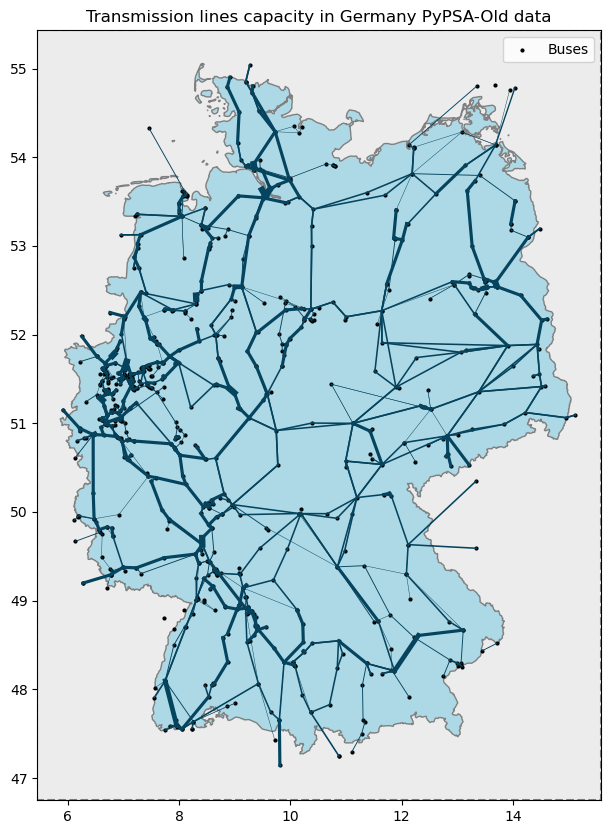

In [8]:
buses_visual=buses_NUTS3
lines_visual=lines_df

# Get the bounding box of the classified buses
bbox = buses_visual.total_bounds  # [minx, miny, maxx, maxy]

# Calculate the center of the bounding box
center = [(bbox[0] + bbox[2]) / 2, (bbox[1] + bbox[3]) / 2]

# Calculate the width and height of the bounding box with a margin
width = bbox[2] - bbox[0]
height = bbox[3] - bbox[1]
new_bbox = box(
    center[0] - width * 0.55, center[1] - height * 0.55,
    center[0] + width * 0.55, center[1] + height * 0.55
)
# Convert the bounding box to a GeoSeries
new_bbox = gpd.GeoSeries([new_bbox], crs=buses_visual.crs)

# plot the lines on a map with the buses with Nuts3 regions here in new_lines_DE x0 and y0 is the starting point and x1 and y1 is the ending point
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_facecolor("#ececec")
germany_nuts3.plot(ax=ax, edgecolor="gray", color="lightblue", alpha=1)#"#ADD8E6")
buses_visual.plot(ax=ax, color="black", label="Buses", markersize=4)
new_bbox.boundary.plot(ax=ax, color="gray", linestyle="--")

for i in range(lines_visual.shape[0]):
    plt.plot([lines_visual['x0'][i], lines_visual['x1'][i]], [lines_visual['y0'][i], lines_visual['y1'][i]], color='#05445e', linewidth=lines_visual['s_nom'][i]/1500, alpha=1)


plt.title("Transmission lines capacity in Germany PyPSA-Old data")
plt.legend()
plt.xlim(new_bbox.total_bounds[0], new_bbox.total_bounds[2])
plt.ylim(new_bbox.total_bounds[1], new_bbox.total_bounds[3])
plt.show()


#### D) Line loading file

In [12]:
line_loading=pd.read_csv(r"C:\Users\par19744\Python_projects\ASSUME_project\ASSUME_Use_case\2035\assume\outputs\line_loading.csv")
line_loading.head(2)

,snapshot,merged_relation/1208415-380-c+1,merged_way/24532884-1-380+6,merged_relation/14592471-380-b+1,way/167261399-1-380,merged_way/36964218-1-380+2,merged_relation/14592735-380-c+1,merged_way/24833555-380+5,merged_way/24428845-1-380+1,merged_way/364135875-380+4,...,way/844126089-380,way/844126090-380,way/87280793-1-380,way/91655776-220,way/92877623-220,way/93258454-220,way/98382716-380,DE-BE,DE-NO,DE-SE
0,0,0.53742,0.53333,0.42948,0.26779,0.064140,0.31775,0.14442,0.39454,0.001913,...,0.012360,0.033083,0.60160,0.529700,0.008639,0.025350,0.29967,0.59025,0.0,0.0
1,1,0.66404,0.66003,0.47833,0.29234,0.074891,0.43888,0.16578,0.43494,0.079621,...,0.012207,0.032689,0.65404,0.082987,0.067261,0.025207,0.46875,0.08025,0.0,0.0


In [13]:
# create a timeseries starting from 2035-01-01 with hourly frequency
time_index = pd.date_range(start='2023-01-01', periods=line_loading.shape[0], freq='H')
line_loading.index = time_index
line_loading.index.name = 'timestamp'
line_loading = line_loading.drop(columns=['snapshot'])
line_loading.head(2)

,merged_relation/1208415-380-c+1,merged_way/24532884-1-380+6,merged_relation/14592471-380-b+1,way/167261399-1-380,merged_way/36964218-1-380+2,merged_relation/14592735-380-c+1,merged_way/24833555-380+5,merged_way/24428845-1-380+1,merged_way/364135875-380+4,relation/1102892-380-b,...,way/844126089-380,way/844126090-380,way/87280793-1-380,way/91655776-220,way/92877623-220,way/93258454-220,way/98382716-380,DE-BE,DE-NO,DE-SE
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-01-01 00:00:00,0.53742,0.53333,0.42948,0.26779,0.064140,0.31775,0.14442,0.39454,0.001913,0.28599,...,0.012360,0.033083,0.60160,0.529700,0.008639,0.025350,0.29967,0.59025,0.0,0.0
2023-01-01 01:00:00,0.66404,0.66003,0.47833,0.29234,0.074891,0.43888,0.16578,0.43494,0.079621,0.24061,...,0.012207,0.032689,0.65404,0.082987,0.067261,0.025207,0.46875,0.08025,0.0,0.0


In [14]:
line_loading1 = (
    line_loading.gt(1)
    .sum()
    .reset_index()
    .rename(columns={0: "Overloaded", "index": "name"})
    .iloc[1:]
)
line_loading1.head(2)

,name,Overloaded
1,merged_way/24532884-1-380+6,133
2,merged_relation/14592471-380-b+1,7


In [15]:
# Merge the DataFrames
lines_loading2 = lines_df.merge(line_loading1, on='name')
lines_loading2.head(2)

,name,bus0,bus1,s_nom,x0,y0,x1,y1,Overloaded
0,merged_way/24532884-1-380+6,way/23380800-380,way/24479984-380,1698.103,6.617347,51.475938,6.656881,51.379623,133
1,merged_relation/14592471-380-b+1,way/25306752-380,way/31131325-380,1698.103,9.425109,48.064602,9.645341,47.744597,7


##### 1) Line loading: Overload frequency

C:\Users\par19744\AppData\Local\Temp\ipykernel_21096\4090301705.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("YlOrRd") #viridis #plasma #cividis #magma #bwr #coolwarm #RdYlBu #RdYlGn #YlGnBu #YlOrRd #Spectral #cubehelix #inferno


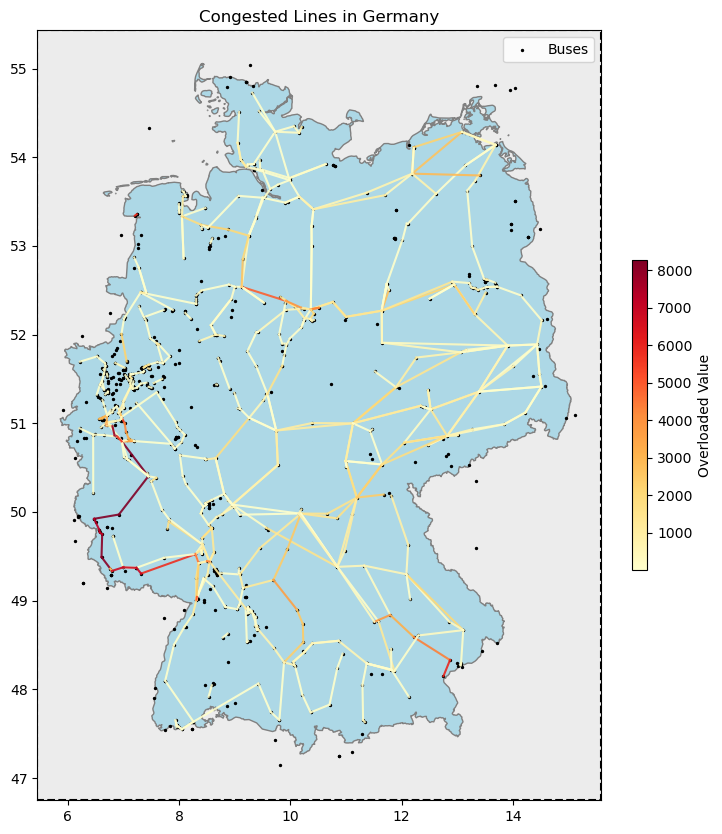

In [16]:
# Filter lines with Overloaded > 0
lines_visual = lines_loading2[lines_loading2["Overloaded"] > 0]

# Normalize based on filtered values
norm = mcolors.Normalize(
    vmin=lines_visual["Overloaded"].min(),
    vmax=lines_visual["Overloaded"].max()
)
cmap = cm.get_cmap("YlOrRd") #viridis #plasma #cividis #magma #bwr #coolwarm #RdYlBu #RdYlGn #YlGnBu #YlOrRd #Spectral #cubehelix #inferno

fig, ax = plt.subplots(figsize=(10, 10))

# Plot Germany outline (transparent fill, only borders)
germany_nuts3.plot(ax=ax, edgecolor="gray", color="lightblue", alpha=1)

# Plot buses
ax.set_facecolor("#ececec")
buses_NUTS3.plot(ax=ax, color="black", markersize=2, label="Buses")

# Plot bounding box
new_bbox.boundary.plot(ax=ax, color="black", linestyle="--")

# Plot overloaded lines
for _, row in lines_visual.iterrows():
    color = cmap(norm(row["Overloaded"]))
    ax.plot(
        [row["x0"], row["x1"]],
        [row["y0"], row["y1"]],
        color=color,
        linewidth=1.5,
        alpha=0.9
    )

# Colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation="vertical", fraction=0.02, pad=0.04)
cbar.set_label("Overloaded Value")

# Titles and limits
plt.title("Congested Lines in Germany")
plt.legend()
plt.xlim(new_bbox.total_bounds[0], new_bbox.total_bounds[2])
plt.ylim(new_bbox.total_bounds[1], new_bbox.total_bounds[3])
plt.show()


In [17]:
line_loading.head(2)

,merged_relation/1208415-380-c+1,merged_way/24532884-1-380+6,merged_relation/14592471-380-b+1,way/167261399-1-380,merged_way/36964218-1-380+2,merged_relation/14592735-380-c+1,merged_way/24833555-380+5,merged_way/24428845-1-380+1,merged_way/364135875-380+4,relation/1102892-380-b,...,way/844126089-380,way/844126090-380,way/87280793-1-380,way/91655776-220,way/92877623-220,way/93258454-220,way/98382716-380,DE-BE,DE-NO,DE-SE
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-01-01 00:00:00,0.53742,0.53333,0.42948,0.26779,0.064140,0.31775,0.14442,0.39454,0.001913,0.28599,...,0.012360,0.033083,0.60160,0.529700,0.008639,0.025350,0.29967,0.59025,0.0,0.0
2023-01-01 01:00:00,0.66404,0.66003,0.47833,0.29234,0.074891,0.43888,0.16578,0.43494,0.079621,0.24061,...,0.012207,0.032689,0.65404,0.082987,0.067261,0.025207,0.46875,0.08025,0.0,0.0


##### 2) Line loading: Intensity of any particular timestamp

Minimum overloaded line at this snapshot: 1.0134
Maximum overloaded line at this snapshot: 12.362


C:\Users\par19744\AppData\Local\Temp\ipykernel_21096\1536610372.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("YlOrRd")  # good sequential map for positive overloads


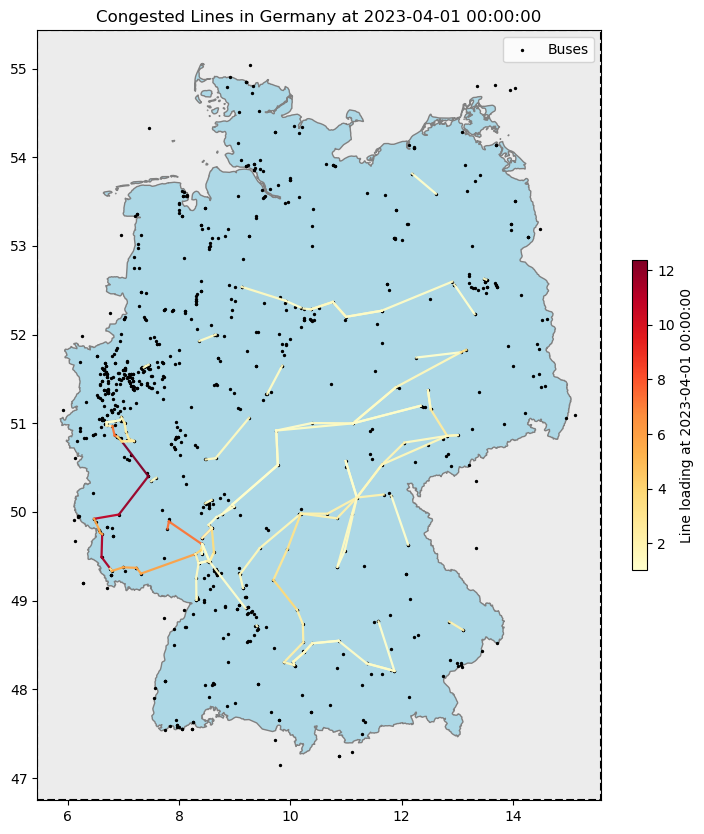

In [20]:
# 1) Pick the snapshot you want (edit this timestamp)
snap_ts = pd.to_datetime("2023-04-01 00:00")

# If the exact timestamp isn't present, use the nearest one
idx = line_loading.index.get_indexer([snap_ts], method="nearest")[0]
snap_ts_actual = line_loading.index[idx]        # actual timestamp used
snap_series = line_loading.iloc[idx]            # Series: index=line names, values=loading at that ts

# 2) Join snapshot load values onto line geometry
lines_snap = (
    lines_loading2
    .set_index("name")
    .join(snap_series.rename("Load"))
    .reset_index()
)

# 3) Keep only overloaded lines at this snapshot
lines_visual = lines_snap[lines_snap["Load"] > 1].copy()

# Guard: if nothing is overloaded, short-circuit with a friendly plot/text
if lines_visual.empty:
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_facecolor("#ececec")
    germany_nuts3.plot(ax=ax, edgecolor="gray", color="lightblue", alpha=1)
    buses_NUTS3.plot(ax=ax, color="black", markersize=2, label="Buses")
    new_bbox.boundary.plot(ax=ax, color="black", linestyle="--")
    ax.set_title(f"No congested lines (>1 pu) at {snap_ts_actual}")
    ax.set_xlim(new_bbox.total_bounds[0], new_bbox.total_bounds[2])
    ax.set_ylim(new_bbox.total_bounds[1], new_bbox.total_bounds[3])
    plt.legend()
    plt.show()
else:
    # 4) Colormap + normalization (handle constant values safely)
    vmin = lines_visual["Load"].min()
    print("Minimum overloaded line at this snapshot:", vmin)
    vmax = lines_visual["Load"].max()
    print("Maximum overloaded line at this snapshot:", vmax)
    if vmin == vmax:
        vmax = vmin + 1e-9  # avoid zero-range norm

    cmap = cm.get_cmap("YlOrRd")  # good sequential map for positive overloads
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

    # 5) Plot
    fig, ax = plt.subplots(figsize=(10, 10))

    # Background / base layers
    ax.set_facecolor("#ececec")
    germany_nuts3.plot(ax=ax, edgecolor="gray", color="lightblue", alpha=1)
    buses_NUTS3.plot(ax=ax, color="black", markersize=2, label="Buses")
    new_bbox.boundary.plot(ax=ax, color="black", linestyle="--")

    # Overloaded lines at the snapshot
    for _, row in lines_visual.iterrows():
        ax.plot(
            [row["x0"], row["x1"]],
            [row["y0"], row["y1"]],
            color=cmap(norm(row["Load"])),
            linewidth=1.6,
            alpha=0.95,
        )

    # Colorbar
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation="vertical", fraction=0.02, pad=0.04)
    cbar.set_label(f"Line loading at {snap_ts_actual}")

    # Titles and limits
    plt.title("Congested Lines in Germany at " + str(snap_ts_actual))
    plt.legend()
    plt.xlim(new_bbox.total_bounds[0], new_bbox.total_bounds[2])
    plt.ylim(new_bbox.total_bounds[1], new_bbox.total_bounds[3])
    plt.show()

##### 3) Line loading: Intensity **Average** over the year

C:\Users\par19744\AppData\Local\Temp\ipykernel_21096\2559604377.py:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("YlOrRd")  # good sequential map for positive overloads


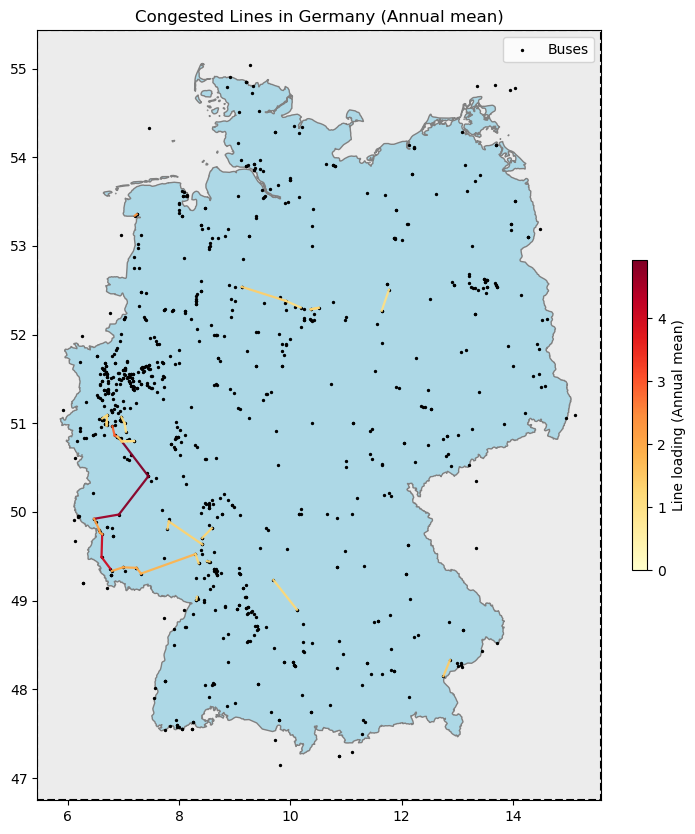

In [19]:
# 1) Average loading per line across all timesteps
avg_series = line_loading.mean(axis=0)  # Series: index=line names, values=avg load

# 2) Join averages onto line geometry
lines_avg = (
    lines_loading2
    .set_index("name")                # ensure this matches your line id column
    .join(avg_series.rename("Load"))  # add column "Load" with average values
    .reset_index()
)

# 3) Keep only lines with average overload > 1 pu
lines_visual = lines_avg[lines_avg["Load"] > 1].copy()

# 4) Handle "no congestion" case
if lines_visual.empty:
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_facecolor("#ececec")
    germany_nuts3.plot(ax=ax, edgecolor="gray", color="lightblue", alpha=1)
    buses_NUTS3.plot(ax=ax, color="black", markersize=2, label="Buses")
    new_bbox.boundary.plot(ax=ax, color="black", linestyle="--")
    ax.set_title("No lines with average loading > 1 pu")
    ax.set_xlim(new_bbox.total_bounds[0], new_bbox.total_bounds[2])
    ax.set_ylim(new_bbox.total_bounds[1], new_bbox.total_bounds[3])
    plt.legend()
    plt.show()

else:
    # 5) Colormap + normalization
    # Option A: normalize to ALL averages (consistent scale across maps)
    vmin = lines_avg["Load"].min()
    vmax = lines_avg["Load"].max()

    # Option B (alternative): normalize only to overloaded ones
    # vmin = lines_visual["Load"].min()
    # vmax = lines_visual["Load"].max()

    if vmin == vmax:
        vmax = vmin + 1e-9  # avoid zero-range
    cmap = cm.get_cmap("YlOrRd")  # good sequential map for positive overloads
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

    # 6) Plot
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_facecolor("#ececec")
    germany_nuts3.plot(ax=ax, edgecolor="gray", color="lightblue", alpha=1)
    buses_NUTS3.plot(ax=ax, color="black", markersize=2, label="Buses")
    new_bbox.boundary.plot(ax=ax, color="black", linestyle="--")

    # Draw overloaded lines with color by average load
    for _, row in lines_visual.iterrows():
        ax.plot(
            [row["x0"], row["x1"]],
            [row["y0"], row["y1"]],
            color=cmap(norm(row["Load"])),
            linewidth=1.6,
            alpha=0.95
        )

    # Colorbar
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation="vertical", fraction=0.02, pad=0.04)
    cbar.set_label("Line loading (Annual mean)")

    # Titles and limits
    plt.title("Congested Lines in Germany (Annual mean)")
    plt.legend()
    plt.xlim(new_bbox.total_bounds[0], new_bbox.total_bounds[2])
    plt.ylim(new_bbox.total_bounds[1], new_bbox.total_bounds[3])
    plt.show()


##### 4) Line loading: Intensity **Maximum** in a year

C:\Users\par19744\AppData\Local\Temp\ipykernel_21096\343976588.py:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("YlOrRd")  # good sequential map for positive overloads


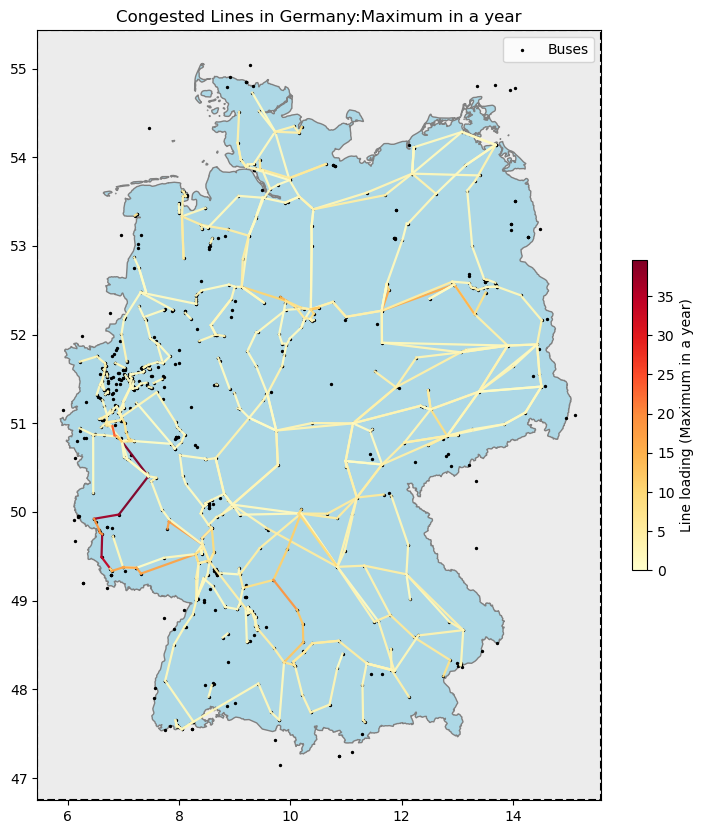

In [21]:
# 1) Average loading per line across all timesteps
avg_series = line_loading.max(axis=0)  # Series: index=line names, values=avg load

# 2) Join averages onto line geometry
lines_avg = (
    lines_loading2
    .set_index("name")                # ensure this matches your line id column
    .join(avg_series.rename("Load"))  # add column "Load" with average values
    .reset_index()
)

# 3) Keep only lines with average overload > 1 pu
lines_visual = lines_avg[lines_avg["Load"] > 1].copy()

# 4) Handle "no congestion" case
if lines_visual.empty:
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_facecolor("#ececec")
    germany_nuts3.plot(ax=ax, edgecolor="gray", color="lightblue", alpha=1)
    buses_NUTS3.plot(ax=ax, color="black", markersize=2, label="Buses")
    new_bbox.boundary.plot(ax=ax, color="black", linestyle="--")
    ax.set_title("No lines with average loading > 1 ")
    ax.set_xlim(new_bbox.total_bounds[0], new_bbox.total_bounds[2])
    ax.set_ylim(new_bbox.total_bounds[1], new_bbox.total_bounds[3])
    plt.legend()
    plt.show()

else:
    # 5) Colormap + normalization
    # Option A: normalize to ALL averages (consistent scale across maps)
    vmin = lines_avg["Load"].min()
    vmax = lines_avg["Load"].max()

    # Option B (alternative): normalize only to overloaded ones
    # vmin = lines_visual["Load"].min()
    # vmax = lines_visual["Load"].max()

    if vmin == vmax:
        vmax = vmin + 1e-9  # avoid zero-range
    cmap = cm.get_cmap("YlOrRd")  # good sequential map for positive overloads
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

    # 6) Plot
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_facecolor("#ececec")
    germany_nuts3.plot(ax=ax, edgecolor="gray", color="lightblue", alpha=1)
    buses_NUTS3.plot(ax=ax, color="black", markersize=2, label="Buses")
    new_bbox.boundary.plot(ax=ax, color="black", linestyle="--")

    # Draw overloaded lines with color by average load
    for _, row in lines_visual.iterrows():
        ax.plot(
            [row["x0"], row["x1"]],
            [row["y0"], row["y1"]],
            color=cmap(norm(row["Load"])),
            linewidth=1.6,
            alpha=0.95
        )

    # Colorbar
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation="vertical", fraction=0.02, pad=0.04)
    cbar.set_label("Line loading (Maximum in a year)")

    # Titles and limits
    plt.title("Congested Lines in Germany:Maximum in a year")
    plt.legend()
    plt.xlim(new_bbox.total_bounds[0], new_bbox.total_bounds[2])
    plt.ylim(new_bbox.total_bounds[1], new_bbox.total_bounds[3])
    plt.show()


#### E) Redispatch Visualization 

##### 1. Clean market_orders data

In [147]:
market_orders=pd.read_csv(r"C:\Users\par19744\Python_projects\ASSUME_project\ASSUME_results\Use case results\2023\with storages\10 days simulation2\example_05d_base\market_orders.csv")
market_orders=market_orders[['market_id','start_time','unit_id','accepted_volume','accepted_price','node']]
print("Number of market orders:", len(market_orders))
market_orders.head(2)

Number of market orders: 1035307


,market_id,start_time,unit_id,accepted_volume,accepted_price,node
0,CRM_pos,2023-01-01 22:00:00,PSPP_Tanzmhle - Rabenleite,35.0,0.0,way/29084374-380
1,CRM_pos,2023-01-01 22:00:00,PSPP_Waldeck I,140.0,0.0,way/41072584-380


In [148]:
# read the csv file powerplant_units.csv
powerplants=pd.read_csv(r'C:\Users\par19744\Python_projects\ASSUME_project\ASSUME_Use_case\2035\assume\examples\inputs\example_05d\powerplant_units.csv')
powerplants=powerplants[['name','technology']]
# rename technologies 'open cycle gas turbine', 'gas steam turbine' , 'combined cycle gas turbine' to 'natural gas'
powerplants['technology'] = powerplants['technology'].replace({
    'open cycle gas turbine': 'natural gas',
    'gas steam turbine': 'natural gas',
    'combined cycle gas turbine': 'natural gas',
    'gas engine': 'natural gas',
    'small gas mix': 'natural gas'
})
# rename the column name to unit_id to merge with redispatch_orders
powerplants = powerplants.rename(columns={'name': 'unit_id'})
powerplants.head(2)

,unit_id,technology
0,Unit_0,natural gas
1,Unit_1,natural gas


In [149]:
storage_units=pd.read_csv(r'C:\Users\par19744\Python_projects\ASSUME_project\ASSUME_Use_case\2035\assume\examples\inputs\example_05d\storage_units.csv')
storage_units=storage_units[['name','technology']]
storage_units = storage_units.rename(columns={'name': 'unit_id'})
storage_units.head(2)

,unit_id,technology
0,battery_li_ion0,li_ion_battery
1,battery_li_ion1,li_ion_battery


In [150]:
# similarly add exchange_units
exchange_units=pd.read_csv(r'C:\Users\par19744\Python_projects\ASSUME_project\ASSUME_Use_case\2035\assume\examples\inputs\example_05d\exchange_units.csv')
# add column technology with value 'exchange'
exchange_units['technology'] = 'exchange_units'
exchange_units=exchange_units[['name','technology']]
exchange_units = exchange_units.rename(columns={'name': 'unit_id'})
exchange_units.head(2)

,unit_id,technology
0,DE_AT_merged_way/26971631-220+1,exchange_units
1,DE_AT_merged_way/30970013-1-380+3,exchange_units


In [151]:
# merge powerplants and storage_units dataframes
units = pd.concat([powerplants, storage_units,exchange_units], ignore_index=True)
print("Unique technologies in powerplants:", units['technology'].unique())
units.head(2)

Unique technologies in powerplants: ['natural gas' 'hard coal' 'lignite' 'oil' 'waste' 'wind offshore'
 'solar pv' 'wind onshore' 'biomass' 'hydro' 'li_ion_battery' 'PSPP'
 'compressed_air_storage' 'exchange_units']


,unit_id,technology
0,Unit_0,natural gas
1,Unit_1,natural gas


In [152]:
# fetch technology for each unit_id in redispatch_orders
market_orders = market_orders.merge(units, left_on='unit_id', right_on='unit_id', how='left')
market_orders.head(2)

,market_id,start_time,unit_id,accepted_volume,accepted_price,node,technology
0,CRM_pos,2023-01-01 22:00:00,PSPP_Tanzmhle - Rabenleite,35.0,0.0,way/29084374-380,PSPP
1,CRM_pos,2023-01-01 22:00:00,PSPP_Waldeck I,140.0,0.0,way/41072584-380,PSPP


In [153]:
# are there any NaN in technology column
nan_tech = market_orders[market_orders['technology'].isna()]
if not nan_tech.empty:
    print("Units with missing technology:")
    print(nan_tech['unit_id'].unique())

# name these technologies as 'demand_units'
market_orders['technology'] = market_orders['technology'].fillna('demand')

Units with missing technology:
['demand_CRM_pos' 'demand_CRM_neg' 'way/32148946-220' 'way/1072574879-380'
 'way/24267175-220' 'way/1071504343-380' 'way/1102237380-380'
 'way/24272541-220' 'way/31762305-220' 'way/42410916-380' 'DE75-380'
 'way/274630377-380' 'way/169244940-380' 'DE199-380' 'way/62061952-380'
 'way/157421333-220' 'way/24757833-380' 'way/26777313-380' 'DE86-220'
 'DE5-380' 'way/59707532-380' 'way/157806991-380' 'DE18-380'
 'way/54359256-380' 'DE41-380' 'DE159-380' 'way/1040551074-220'
 'way/39011884-220' 'DE195-380' 'way/26404600-380' 'way/1245867884-380'
 'way/25306752-380' 'way/83916207-220' 'way/22973052-220'
 'way/30017786-220' 'way/25992879-380' 'DE171-220' 'DE173-220'
 'way/940636813-380' 'way/951773852-380' 'way/53378027-380' 'DE127-380'
 'way/42423415-380' 'way/32966636-220' 'DE109-220' 'DE117-380'
 'way/147878692-380' 'DE96-380' 'way/27919734-380' 'way/202865177-380'
 'DE22-380' 'way/91086220-220' 'DE104-380' 'way/28327356-380' 'DE169-220'
 'way/25044557-380' 'wa

In [154]:
# group by technology, market_id, start_time, node and sum accepted_volume and average accepted_price
market_orders_merged = market_orders.groupby(['market_id', 'start_time', 'technology','node']).agg({
    'accepted_volume': 'sum',
    'accepted_price': 'mean'
}).reset_index()

print("Number of market orders:", len(market_orders))
print("Number of market orders(Merged):", len(market_orders_merged))

Number of market orders: 1035307
Number of market orders(Merged): 914638


##### 2) Plot a bar graph for redispatch costs over time

In [155]:
# Filter for market_id 'EOM' 
eom_orders_merged = market_orders_merged[market_orders_merged['market_id'] == 'EOM']
eom_orders_merged.head(2)

,market_id,start_time,technology,node,accepted_volume,accepted_price
56540,EOM,2023-01-02 00:00:00,PSPP,DE151-220,0.0,113.99
56541,EOM,2023-01-02 00:00:00,PSPP,DE169-220,0.0,113.99


In [156]:
# Filter for market_id 'redispatch'
redispatch_orders_merged = market_orders_merged[market_orders_merged['market_id'] == 'redispatch']
redispatch_orders_merged.head(2)

,market_id,start_time,technology,node,accepted_volume,accepted_price
435790,redispatch,2023-01-02 00:00:00,PSPP,DE151-220,94.63,19.9005
435791,redispatch,2023-01-02 00:00:00,PSPP,DE169-220,168.00,39.8010


In [157]:
# Filter for market_id 'CRM_neg' and 'CRM_pos'
crm_orders_merged = market_orders_merged[market_orders_merged['market_id'].isin(['CRM_neg', 'CRM_pos'])]
crm_orders_merged.head(2)

,market_id,start_time,technology,node,accepted_volume,accepted_price
0,CRM_neg,2023-01-01 22:00:00,PSPP,DE151-220,0.0,0.0
1,CRM_neg,2023-01-01 22:00:00,PSPP,DE169-220,154.0,0.0


In [158]:
TECH_COLORS = {
    # Dispatchable / fossil
    "hard coal": "#000000",        # black
    "lignite": "#3E2723",          # dark brown
    "natural gas": "#BDBDBD",      # light gray
    "oil": "#616161",              # dark gray
    "waste": "#A1887F",            # light brown

    # Renewables
    "solar pv": "#FDD835",         # yellow
    "wind offshore": "#1E88E5",    # blue
    "wind onshore": "#0D47A1",     # navy blue
    "biomass": "#2E7D32",          # green
    "hydro": "#26C6DA",            # turquoise

    # Storage
    "li_ion_battery": "#D32F2F",   # red
    "PSPP": "#81D4FA",             # light blue
    "compressed_air_storage": "#FB8C00",  # orange

    # Backup and exchange
    "demand": "#F48FB1",     # pink
    "exchange_units": "#6A1B9A",   # purple
}

In [167]:
def plot_stacked_volume_by_tech(
    df,
    title,
    time_col="start_time",
    tech_col="technology",
    vol_col="accepted_volume",
    tech_colors=None,
):
    d = df.copy()
    d[time_col] = pd.to_datetime(d[time_col])
    d[vol_col] = pd.to_numeric(d[vol_col], errors="coerce").fillna(0.0)

    # ---- date range ----
    start_date = d[time_col].min().strftime("%Y-%m-%d")
    end_date   = d[time_col].max().strftime("%Y-%m-%d")
    title = f"{title} ({start_date} → {end_date})"
    # --------------------

    pivot = (d.groupby([time_col, tech_col])[vol_col]
               .sum()
               .unstack(tech_col)
               .fillna(0.0)
               .sort_index())

    if tech_colors is not None:
        colors = [tech_colors.get(col, "#BDBDBD") for col in pivot.columns]
    else:
        colors = None

    ax = pivot.plot(
        kind="bar",
        stacked=True,
        figsize=(16, 7),
        color=colors,
        #width=1.0,  # no gaps
    )

    ax.set_xlabel("Time")
    ax.set_ylabel("Accepted volume (MW)")
    ax.set_title(title)

    ax.legend(
        title="Technology",
        bbox_to_anchor=(1.02, 1),
        loc="upper left",
    )

    # cleaner x-axis
    step = max(len(pivot) // 10, 1)
    ax.set_xticks(range(0, len(pivot), step))
    ax.set_xticklabels(
        pivot.index.strftime("%m-%d %H:%M")[::step],
        rotation=45,
        ha="right",
    )

    plt.tight_layout()
    plt.show()


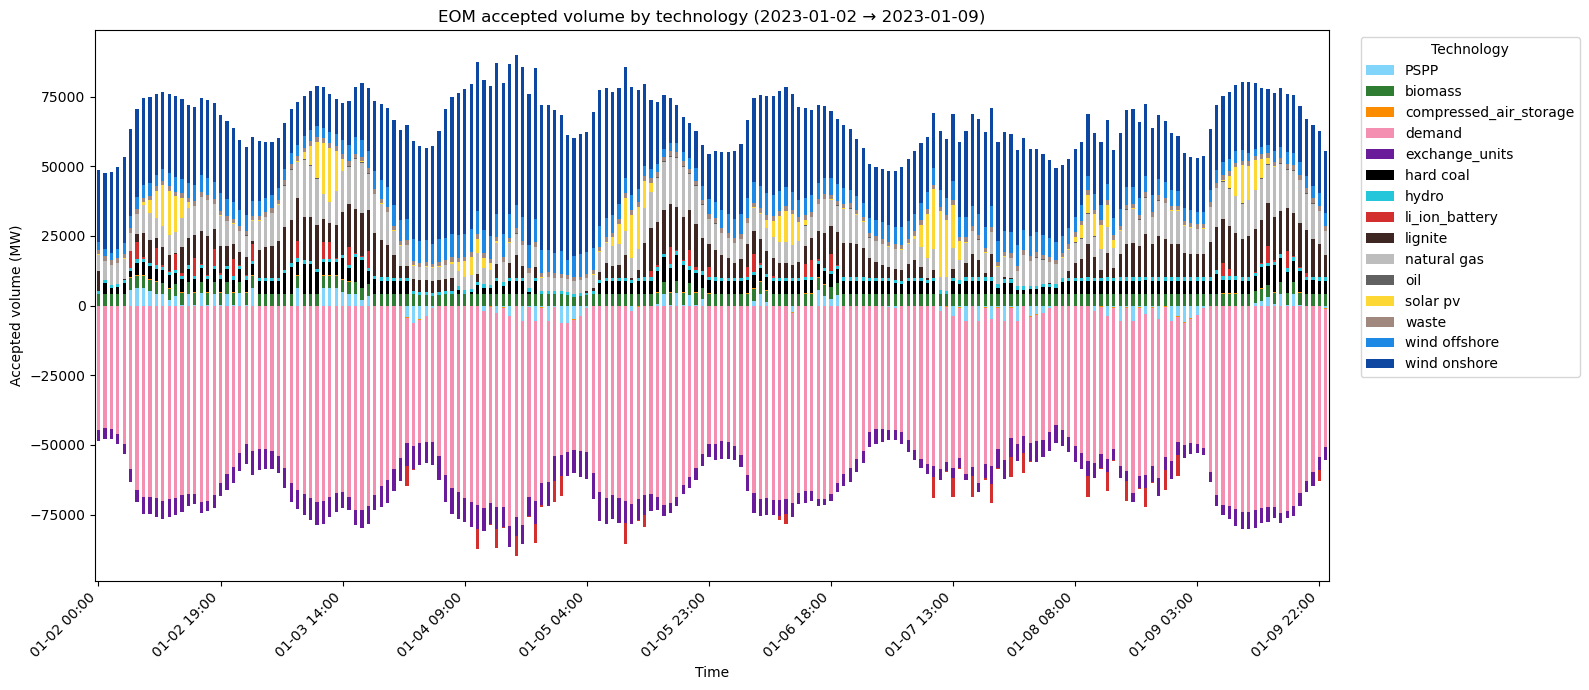

In [168]:
plot_stacked_volume_by_tech(
    eom_orders_merged,
    title="EOM accepted volume by technology",
    tech_colors=TECH_COLORS,
)

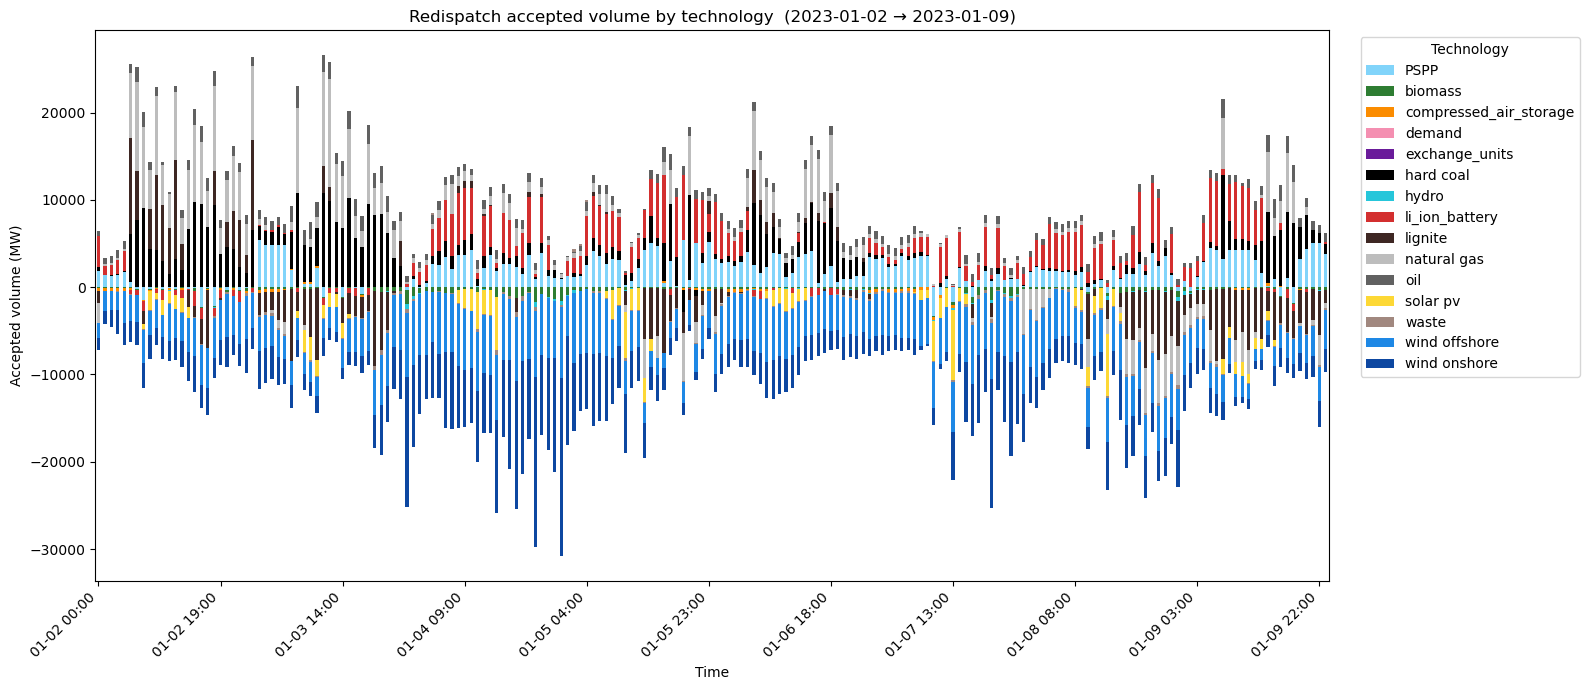

In [169]:
plot_stacked_volume_by_tech(
    redispatch_orders_merged,
    title="Redispatch accepted volume by technology ",
    tech_colors=TECH_COLORS,
)

In [172]:
net = redispatch_orders_merged.groupby("start_time")["accepted_volume"].sum()
print("Max |net| MW:", net.abs().max())

Max |net| MW: 29160.1297


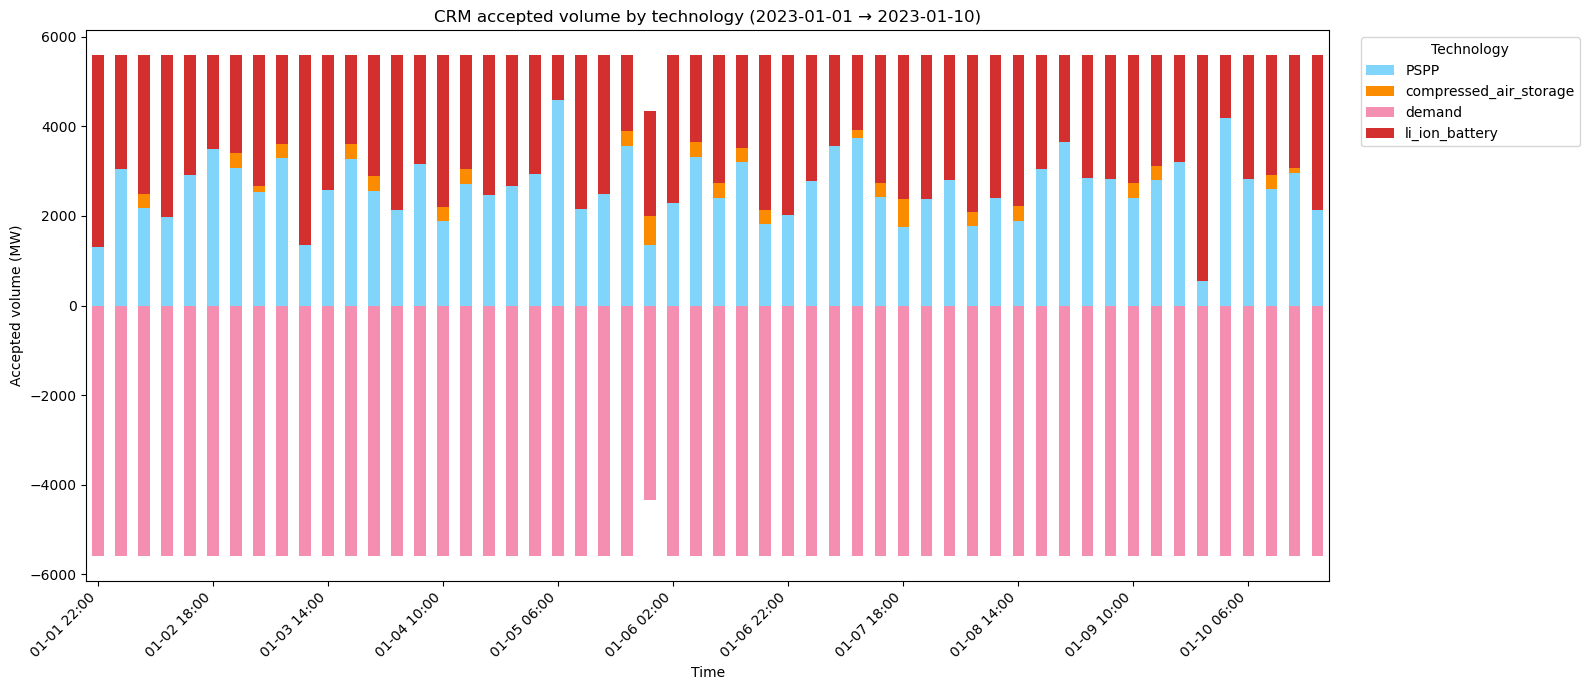

In [170]:
plot_stacked_volume_by_tech(
    crm_orders_merged,
    title="CRM accepted volume by technology",
    tech_colors=TECH_COLORS,
)

In [143]:
# sum of the -ve accepted volume
total_down = redispatch_orders_merged[redispatch_orders_merged["accepted_volume"] < 0]["accepted_volume"].sum()
total_down

-8097218.315633001

In [144]:
# sum of the +ve accepted volume
total_up = redispatch_orders_merged[redispatch_orders_merged["accepted_volume"] > 0]["accepted_volume"].sum()
total_up

8005318.266485999

In [34]:
# Redispatch cost is equal to the accepted_volume * accepted_price for a particular snapshot
redispatch_orders.loc[:, "redispatch_cost"] = (
    redispatch_orders["accepted_volume"].abs() * redispatch_orders["accepted_price"]
)

# Then group & sum as before
redispatch_costs = (
    redispatch_orders.groupby("start_time")["redispatch_cost"].sum().reset_index()
)
redispatch_costs.head(2)

,start_time,redispatch_cost
0,2023-01-02 00:00:00,943195.142302
1,2023-01-02 01:00:00,584276.767767


In [35]:
# unique start_time in redispatch_cost
unique_times = redispatch_costs["start_time"].unique()
print(f"Unique start_time values in redispatch_costs: {len(unique_times)}")

Unique start_time values in redispatch_costs: 24


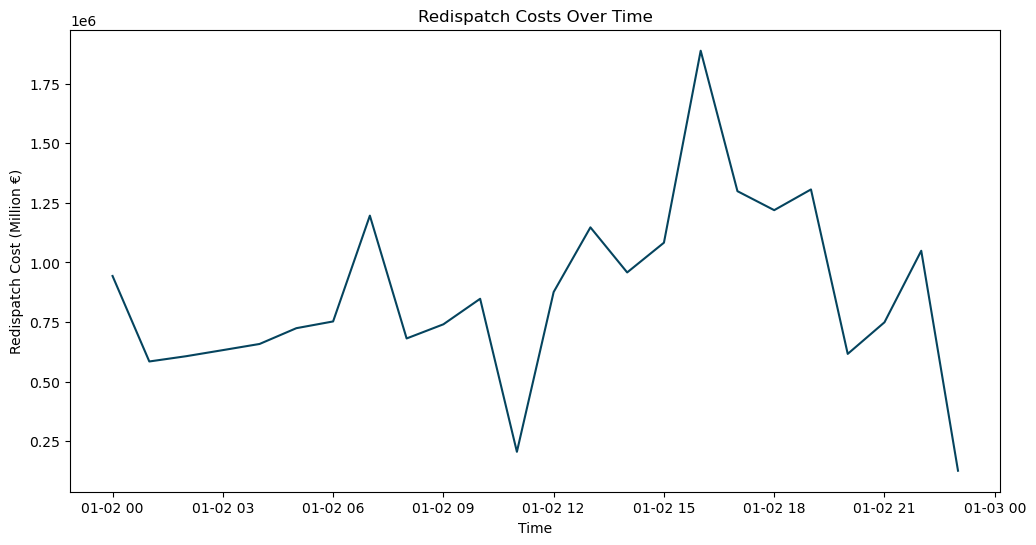

In [16]:
# plot the redispatch costs time series
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(
    pd.to_datetime(redispatch_costs["start_time"]),
    redispatch_costs["redispatch_cost"],
    color="#05445e",
    linewidth=1.5,
)
ax.set_title("Redispatch Costs Over Time")
ax.set_xlabel("Time")
ax.set_ylabel("Redispatch Cost (Million €)")
plt.show()

##### 2) Plot a bar graph for redispatch by powerplants for one snapshot

In [17]:
snapshot = redispatch_orders["start_time"].unique()[0]
filtered = redispatch_orders[redispatch_orders["start_time"] == snapshot]
filtered

,market_id,start_time,unit_id,accepted_volume,accepted_price,node,redispatch_cost
66636,redispatch,2023-01-02 00:00:00,Unit_246,-39.312,0.0,way/1076001174-380,0.0
66660,redispatch,2023-01-02 00:00:00,Unit_307,-147.430,0.0,DE64-220,0.0
66682,redispatch,2023-01-02 00:00:00,Unit_287,-97.544,0.0,way/24757392-380,0.0
66696,redispatch,2023-01-02 00:00:00,Unit_236,-38.400,0.0,DE130-380,0.0
66711,redispatch,2023-01-02 00:00:00,Unit_298,-30.598,0.0,DE108-220,0.0
...,...,...,...,...,...,...,...
130427,redispatch,2023-01-02 00:00:00,Unit_949,0.000,0.0,way/274603394-380,0.0
130444,redispatch,2023-01-02 00:00:00,Unit_954,0.000,0.0,way/274630377-380,0.0
130460,redispatch,2023-01-02 00:00:00,Unit_956,0.000,0.0,way/275138524-380,0.0
130500,redispatch,2023-01-02 00:00:00,Unit_33,0.000,0.0,way/229565743-220,0.0


In [18]:
# filter unit_id which starts with battery 
filtered_battery = filtered[filtered["unit_id"].str.startswith("battery")]
filtered_battery.head(2)

,market_id,start_time,unit_id,accepted_volume,accepted_price,node,redispatch_cost
67902,redispatch,2023-01-02 00:00:00,battery_li_ion0,-4.5192,39.801,DE1-220,179.868679
67920,redispatch,2023-01-02 00:00:00,battery_li_ion1,-5.5062,39.801,DE10-380,219.152266


In [19]:
filtered_battery.shape

(531, 7)

In [20]:
# filter accepted volume > 0 (Upward Redispatch)
filtered_battery_up = filtered_battery[filtered_battery["accepted_volume"] > 0]

filtered_battery_down = filtered_battery[filtered_battery["accepted_volume"] < 0]

In [21]:
# Then group & sum as before
filtered_battery_up_cum = (
    filtered_battery_up.groupby("start_time")["accepted_volume"].sum().reset_index()
)
filtered_battery_up_cum.head(20)

,start_time,accepted_volume
0,2023-01-02 00:00:00,117.2992


In [22]:
# Then group & sum as before
filtered_battery_down_cum = (
    filtered_battery_up.groupby("start_time")["accepted_volume"].sum().reset_index()
)
filtered_battery_up.head(2)

,market_id,start_time,unit_id,accepted_volume,accepted_price,node,redispatch_cost
68996,redispatch,2023-01-02 00:00:00,battery_li_ion154,6.8551,39.801,way/1102237380-380,272.839835
72279,redispatch,2023-01-02 00:00:00,battery_li_ion321,55.2770,39.801,way/27124619-220,2200.079877


In [23]:
snapshot="2023-12-02 00:00:00"

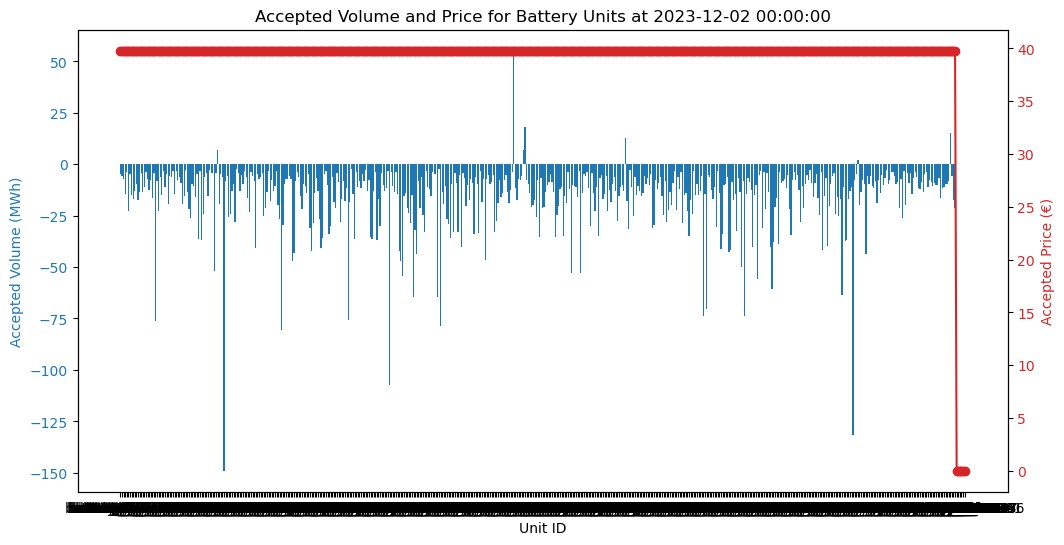

In [24]:
# plot accepted_volume and accepted_price for filtered_battery over start_time
fig, ax1 = plt.subplots(figsize=(12, 6))
color = 'tab:blue'
ax1.set_xlabel('Unit ID')
ax1.set_ylabel('Accepted Volume (MWh)', color=color)
ax1.bar(filtered_battery['unit_id'], filtered_battery['accepted_volume'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Accepted Price (€)', color=color)
ax2.plot(filtered_battery['unit_id'], filtered_battery['accepted_price'], color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)
plt.title(f'Accepted Volume and Price for Battery Units at {snapshot}')
plt.xticks(rotation=45)
plt.show()

#### F) Market Meta

##### I) 2023 BAU

In [25]:
market_meta_2023_BAU=pd.read_csv(r"C:\Users\par19744\Python_projects\ASSUME_project\ASSUME_Use_case\2035\assume\examples\outputs\example_05d_base\market_meta.csv")
market_meta_2023_BAU.head(2)

,Unnamed: 0,demand_volume,demand_volume_energy,market_id,max_price,min_price,node,only_hours,price,product_end,product_start,simulation,supply_volume,supply_volume_energy,time
0,0,2756.0,11024.0,CRM_pos,0.0,0.0,NaN,NaN,0.0,2023-01-02 02:00:00,2023-01-01 22:00:00,example_05d_base,2756.0,11024.0,2023-01-01 22:00:00
1,1,2827.0,11308.0,CRM_neg,0.0,0.0,NaN,NaN,0.0,2023-01-02 02:00:00,2023-01-01 22:00:00,example_05d_base,2827.0,11308.0,2023-01-01 22:00:00


In [26]:
# Filter EOM markets and make a copy to avoid warnings
eom_2023_BAU = market_meta_2023_BAU[market_meta_2023_BAU["market_id"] == "EOM"].copy()
# Convert time column
eom_2023_BAU["time"] = pd.to_datetime(eom_2023_BAU["time"])
# Keep only needed columns
eom_2023_BAU = eom_2023_BAU[["time", "price"]]
# Set time index
eom_2023_BAU = eom_2023_BAU.set_index("time").sort_index()
# Create full hourly index for 2035
time_index = pd.date_range("2023-01-01 00:00:00", "2023-12-31 23:00:00", freq="H")
# Reindex to full time range
eom_2023_BAU_full = eom_2023_BAU.reindex(time_index)
# Name the index
eom_2023_BAU_full.index.name = "timestamp"
# Fill missing prices with 0 (or something else)
eom_2023_BAU_full["price"] = eom_2023_BAU_full["price"].fillna(0)
# Final dataframe
eom_2023_BAU_full = eom_2023_BAU_full.reset_index()[["timestamp", "price"]]
eom_2023_BAU_full.head(2)

,timestamp,price
0,2023-01-01 00:00:00,0.0
1,2023-01-01 01:00:00,0.0


In [27]:
# count the number of rows
display(eom_2023_BAU_full.shape[0])

8760